# Generate Headlines using LSTM 

# Import Packages

In [1]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
from keras.utils import np_utils
import tensorflow

# set seeds for reproducability
from numpy.random import seed
tensorflow.random.set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Pre-Proccessing

## Extract headlines from all the three .csv files 

In [2]:
curr_dir = '/LSTM/Articles/'
all_headlines = []
for filename in os.listdir(curr_dir):
    print(filename)
    if 'articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.title.values))

all_headlines = [h for h in all_headlines if type(h) == str]
len(all_headlines)

articles1.csv
articles2.csv
articles3.csv


142568

In [3]:
all_headlines[:10]

['House Republicans Fret About Winning Their Health Care Suit - The New York Times',
 'Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times',
 'Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times',
 'Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times',
 'Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times',
 'Sick With a Cold, Queen Elizabeth Misses New Year’s Service - The New York Times',
 'Taiwan’s President Accuses China of Renewed Intimidation - The New York Times',
 'After ‘The Biggest Loser,’ Their Bodies Fought to Regain Weight - The New York Times',
 'First, a Mixtape. Then a Romance. - The New York Times',
 'Calling on Angels While Enduring the Trials of Job - The New York Times']

## Cleaning the Data 

- Remove ' - The New York Times'
- Remove punctuations and turn into lowercase
- Ignore symbols

In [4]:
import re
def clean_text(txt):
    t = txt
    if 'The New York Times' in txt:
        t = txt.replace('The New York Times','')
    t = re.sub(r'[^\w\s]', '', t).lower()
    t = t.encode("utf8").decode("ascii",'ignore')
    return t 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['house republicans fret about winning their health care suit  ',
 'rift between officers and residents as killings persist in south bronx  ',
 'tyrus wong bambi artist thwarted by racial bias dies at 106  ',
 'among deaths in 2016 a heavy toll in pop music  ',
 'kim jongun says north korea is preparing to test longrange missile  ',
 'sick with a cold queen elizabeth misses new years service  ',
 'taiwans president accuses china of renewed intimidation  ',
 'after the biggest loser their bodies fought to regain weight  ',
 'first a mixtape then a romance  ',
 'calling on angels while enduring the trials of job  ']

In [8]:
corpus = corpus[::3]

# Tokenization

In [9]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[53, 129],
 [53, 129, 5752],
 [53, 129, 5752, 25],
 [53, 129, 5752, 25, 721],
 [53, 129, 5752, 25, 721, 77],
 [53, 129, 5752, 25, 721, 77, 107],
 [53, 129, 5752, 25, 721, 77, 107, 170],
 [53, 129, 5752, 25, 721, 77, 107, 170, 1243],
 [2658, 1],
 [2658, 1, 326]]

# Padding the Sequences and obtain Variables

In [10]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = np_utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

# Create LSTM Model

In [14]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 10)            182640    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 18264)             1844664   
Total params: 2,071,704
Trainable params: 2,071,704
Non-trainable params: 0
_________________________________________________________________


### Train the Model 

In [15]:
lstm = model.fit(predictors, label, epochs=30, verbose=1)

Epoch 1/30
3333/3333 [==============================] - 161s 47ms/step - loss: 8.1620
Epoch 2/30
3333/3333 [==============================] - 152s 46ms/step - loss: 7.7371
Epoch 3/30
3333/3333 [==============================] - 149s 45ms/step - loss: 7.5004
Epoch 4/30
3333/3333 [==============================] - 179s 54ms/step - loss: 7.2663
Epoch 5/30
3333/3333 [==============================] - 164s 49ms/step - loss: 7.0321
Epoch 6/30
3333/3333 [==============================] - 163s 49ms/step - loss: 6.8009
Epoch 7/30
3333/3333 [==============================] - 156s 47ms/step - loss: 6.5785
Epoch 8/30
3333/3333 [==============================] - 157s 47ms/step - loss: 6.3621
Epoch 9/30
3333/3333 [==============================] - 150s 45ms/step - loss: 6.1497
Epoch 10/30
3333/3333 [==============================] - 136s 41ms/step - loss: 5.9382
Epoch 11/30
3333/3333 [==============================] - 129s 39ms/step - loss: 5.7351
Epoch 12/30
3333/3333 [=============================

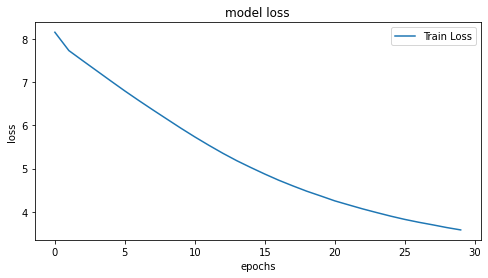

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(lstm.history['loss'], label='Train Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

# Predictions

In [22]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [46]:
print(generate_text("china", 8, model, max_sequence_len))
print(generate_text("rescue", 9, model, max_sequence_len))
print(generate_text("donald trump", 10, model, max_sequence_len))
print(generate_text("elon musk", 8, model, max_sequence_len))
print(generate_text("game of thrones", 9, model, max_sequence_len))

China Is Making The Worst System To Be Up
Rescue Says Syria Student Is Serious For Gun Control Dies
Donald Trump And Bikers Share Affection To Be President To Shut Out
Elon Musk Says Robots Is A Bad Computer Reality Breitbart
Game Of Thrones Season 6 Episode Tom Homes Are Going To Save
